# Treinamento com interface de alto nível

O objetivo deste notebook é ilustrar o uso da biblioteca `pytorch_trainer` que permite uma programação de mais alto nível.

Os conceitos importantes são:
- classe DeepNetTrainer:
    - responsável pelo treinamento com praticamente todas as opções possíveis
    - uso de 8 entry points para uso de callbacks:
        - início de treinamento
            - início de época
                - início de minibatch de treinamento
                - final de minibatch de treinamento
                - início de minibatch de validação
                - final de minibatch de validação
            - final de época
        - final de treinamento
- classe Callback
    - permite a implementação de vários callbacks úteis:
        - AccuracyMetric: cálculo da acurácia
        - PrintCallback:  impressão das métricas durante treinamento
        - ModelCheckpoint:salva modelo sempre que loss de validação é melhor

## Importação das bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

import lib.pytorch_trainer as ptt

## Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras de validação.

In [2]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

## Visualizando os dados

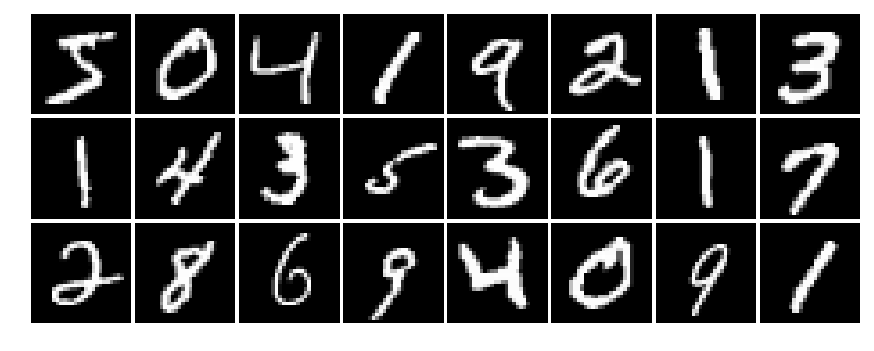

In [3]:
N = 24
grid = torchvision.utils.make_grid(x_train[:N].unsqueeze(1), normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Criação da rede

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.at1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.at1(x)
        x = self.fc2(x)
        return x
    
model = Model()
model

Model (
  (fc1): Linear (784 -> 50)
  (at1): ReLU ()
  (fc2): Linear (50 -> 10)
)

## Treinamento

In [23]:
chkpt_cb = ptt.ModelCheckpoint('../../models/MNIST_neuralnet', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.SGD(model.parameters(),lr=0.03),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [24]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test))

Start training for 20 epochs
  1:   0.2s   T: 2.00417 0.47400   V: 1.68731 0.66200 best
  2:   0.2s   T: 1.16187 0.75100   V: 1.04097 0.70400 best
  3:   0.1s   T: 0.72644 0.81800   V: 0.78424 0.77600 best
  4:   0.2s   T: 0.55593 0.86100   V: 0.66617 0.80000 best
  5:   0.1s   T: 0.45883 0.88300   V: 0.60442 0.82000 best
  6:   0.1s   T: 0.39810 0.88800   V: 0.54052 0.82800 best
  7:   0.1s   T: 0.35607 0.90600   V: 0.53445 0.83000 best
  8:   0.2s   T: 0.32308 0.90700   V: 0.49778 0.83600 best
  9:   0.1s   T: 0.29219 0.92300   V: 0.47687 0.85200 best
 10:   0.3s   T: 0.26974 0.94000   V: 0.46547 0.85000 best
 11:   0.2s   T: 0.24550 0.93500   V: 0.45267 0.86400 best
 12:   0.1s   T: 0.23200 0.94400   V: 0.45468 0.85000 
 13:   0.1s   T: 0.21385 0.94400   V: 0.44620 0.85600 best
 14:   0.1s   T: 0.19463 0.95400   V: 0.43275 0.86200 best
 15:   0.1s   T: 0.18276 0.95700   V: 0.42747 0.86800 best
 16:   0.1s   T: 0.16771 0.96500   V: 0.42484 0.87000 best
 17:   0.1s   T: 0.15771 0.9650

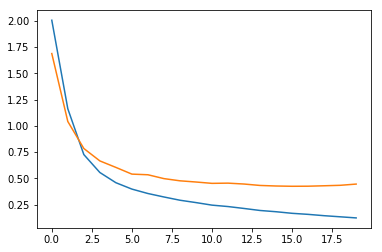

In [25]:
histo_loss_val = trainer.metrics['valid']['losses']
histo_loss_tra = trainer.metrics['train']['losses']
epochs = np.arange(len(histo_loss_val))
plt.plot(epochs,histo_loss_tra, epochs,histo_loss_val)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de validação

### Recuperando o modelo da melhor época

In [26]:
trainer.load_state('../../models/MNIST_neuralnet')

In [27]:
acc_train = trainer.evaluate(x_train,y_train, metrics=[ptt.AccuracyMetric()])
acc_val = trainer.evaluate(x_test,y_test, metrics=[ptt.AccuracyMetric()])

evaluate: 99/99 ok
evaluate: 49/49 ok


In [28]:
print('Training Accuracy:   {:f}'.format(acc_train['acc']))
print('Validation Accuracy: {:f}'.format(acc_val['acc']))

Training Accuracy:   0.966000
Validation Accuracy: 0.870000


## Matriz de confusão com dados de treinamento e validação

In [29]:
y_pred = torch.max(trainer.predict(x_train),1)[1]

predict: 99/99 ok


In [30]:
pd.crosstab(y_pred.numpy(),y_train.numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,1,0,0,0,1,0,0,1
1,0,113,1,0,0,0,1,1,0,0
2,0,0,93,2,0,1,1,1,0,0
3,0,0,0,89,0,1,0,0,0,0
4,0,0,0,0,104,2,0,1,0,1
5,0,1,0,1,0,86,0,0,0,1
6,0,0,1,0,0,1,91,0,0,0
7,0,0,1,0,0,0,0,112,0,2
8,0,2,1,0,0,0,0,0,87,1


In [31]:
y_val_pred = torch.max(trainer.predict(x_test),1)[1]

predict: 49/49 ok


In [32]:
pd.crosstab(y_val_pred.numpy(),y_test.numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,42,0,1,0,0,1,1,0,2,0
1,0,67,0,0,0,1,0,0,0,0
2,0,0,47,1,0,0,1,4,0,0
3,0,0,1,37,0,1,0,2,0,3
4,0,0,0,0,49,0,2,2,1,0
5,0,0,0,7,0,38,3,0,1,0
6,0,0,1,0,3,2,36,0,0,0
7,0,0,3,0,0,3,0,39,1,2
8,0,0,1,0,0,3,0,0,32,1


## Exercícios

1. Implemente e teste uma classe de callback para imprimir o número do miniback e o número da época durante o treinamento.
2. Implemente e teste uma classe de callback para imprimir o valor médio e a variância dos pesos da primeira camada da rede à medida que ela é treinada.

## Aprendizados